# Data Loading & Sampling

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

df = pd.read_csv('/content/yelp.csv')

reviews = df.sample(
    min(2000, len(df)),
    random_state=42
)

print("Sampled reviews:", len(reviews))



Sampled reviews: 2000


#Sentiment Model (Roberta)

Using a pretrained RoBERTa transformer fine-tuned for sentiment classification.The model outputs probabilities for negative, neutral, and positive tone for each review in the sample.

In [2]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [40]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    )
    output = model(**encoded_text)
    scores = output.logits[0].detach().numpy()
    scores = softmax(scores)
    return {
        "neg": scores[0],
        "neu": scores[1],
        "pos": scores[2]
    }

reviews["clean_text"] = reviews["text"].astype(str).str.lower()
reviews["sentiment"] = reviews["clean_text"].apply(
    polarity_scores_roberta
)

reviews["pos_score"] = reviews["sentiment"].apply(
    lambda x: x["pos"]
)



#Validation

Verified model reliability by comparing predicted positivity
with user star ratings. Higher-rated reviews proved to exhibit
higher positive sentiment.

In [20]:
reviews.groupby("stars")["pos_score"].mean()


,pos_score
stars,
1,0.083401
2,0.237881
3,0.609960
4,0.858700
5,0.913533


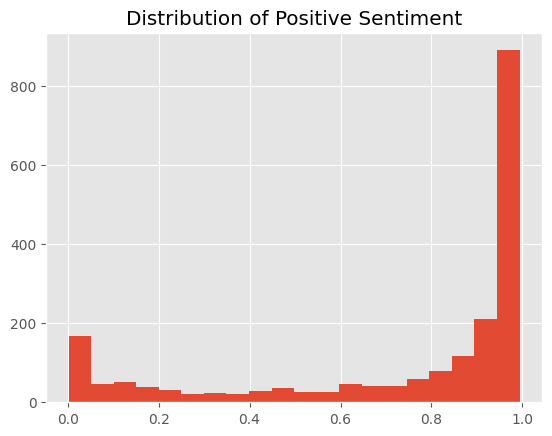

In [21]:
import matplotlib.pyplot as plt

reviews["pos_score"].hist(bins=20)
plt.title("Distribution of Positive Sentiment")
plt.xlabel("Positive Sentiment Score")
plt.ylabel("Frequency")
plt.show()


In [22]:
reviews[reviews["stars"] <= 2]["text"].head(10)



,text
4742,"My husband and I were really, really disappoin..."
439,"1 star for service, but the food is not ok :( ..."
6033,So I was pretty excited about this burger join...
4640,"Staff was very rude, bowling prices weren't di..."
1963,Prices are often way too high!
6590,The wood saw is always out of service...\nThe ...
8847,I've never been to a restaurant where we (a pa...
321,"My wife and I live around the corner, hadn't e..."
2678,"Ok, so I have to share my morning experience. ..."
6630,Well I just wasted 38 bucks....never again


In [41]:
reviews[reviews["stars"] >= 4]["text"].head(10)
print(
    reviews[["stars", "pos_score"]].corr()
)

print("MOST NEGATIVE:")
print(reviews.sort_values("pos_score").iloc[0]["text"])

print("\nMOST POSITIVE:")
print(reviews.sort_values("pos_score", ascending=False).iloc[0]["text"])



              stars  pos_score
stars      1.000000   0.743796
pos_score  0.743796   1.000000
MOST NEGATIVE:
I will never go back to this establishment because all of the bouncers and wait staff are unfriendly, unprofessional and disrespectful.

MOST POSITIVE:
Good food, great atmosphere, great service and great prices! We will definitely be back! Can't wait to try the Sunday Brunch!


#Angry Reviews

Sorted by filtering for low-star ratings.


In [24]:
angry = reviews[df["stars"] <= 2]

print("Angry reviews:", len(angry))
angry["text"].head()


Angry reviews: 308


/tmp/ipython-input-2590552671.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  angry = reviews[df["stars"] <= 2]


,text
4742,"My husband and I were really, really disappoin..."
439,"1 star for service, but the food is not ok :( ..."
6033,So I was pretty excited about this burger join...
4640,"Staff was very rude, bowling prices weren't di..."
1963,Prices are often way too high!


In [26]:
import re

def clean_words(text):
    text = re.sub(r"[^a-z\s]", "", text.lower())
    return text

angry["clean"] = angry["text"].apply(clean_words).copy()


/tmp/ipython-input-423481409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  angry["clean"] = angry["text"].apply(clean_words).copy()


In [19]:
reviews["text"].sample(10, random_state=42)


,text
4343,Let's cut the witty intro and get right down t...
1794,I love the place. Was a bit hesitant at first...
708,Today I was ready to be beside myself with gle...
3383,You would think with the economy being what it...
4534,"I found this place on Yelp, and went there for..."
7936,Lots of people to help but too busy talking to...
6808,you will wait... ALWAYS...\n\nI COULD EAT A PO...
4607,I am a huge fan of the Italian beef and of cou...
8187,"Ahh man,\n.....I REALLY wanted this to be good..."
6481,When I was a dancer I always came here for eve...


In [27]:
words = angry["clean"].str.split().explode()


#NLTK
removing common filler words to find more meaningful reasons on what makes people give negative reviews

In [34]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

words = words[~words.isin(stop)]
extra_stopwords = {
    "food","place","like","one","get","go","back",
    "really","would","time","even","im","dont",
    "didnt","got","ordered","order","restaurant","us","great","bad","better","could","ive"
}
words = words[~words.isin(extra_stopwords)]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
from collections import Counter

common = Counter(words).most_common(20)
common[:10]


[('good', 167),
 ('service', 142),
 ('said', 82),
 ('way', 66),
 ('know', 66),
 ('never', 66),
 ('people', 66),
 ('going', 65),
 ('minutes', 64),
 ('menu', 64)]

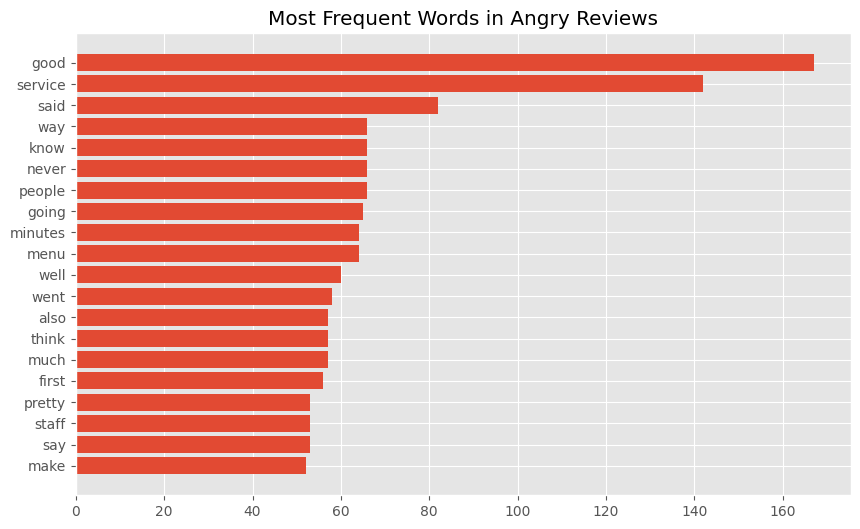

In [42]:
import pandas as pd

common_df = pd.DataFrame(common, columns=["word", "count"])

plt.figure(figsize=(10,6))
plt.barh(common_df["word"], common_df["count"])
plt.gca().invert_yaxis()
plt.title("Most Frequent Words in Angry Reviews")
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.show()
